
# 🧠 Yield Curve Inversions and USD Strength — A Quantitative Macro Analysis
**Author:** Alex Dunn  
**Goal:** Automate macroeconomic data retrieval and analyze the relationship between U.S. yield curve inversions and USD appreciation.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from pandas_datareader import data as pdr
import yfinance as yf
import statsmodels.api as sm


## 🌐 Data Acquisition (FRED + FX Rates)

In [ ]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime.today()

series = ['DGS10', 'DGS2']
yields = pdr.DataReader(series, 'fred', start, end)

fx_pairs = ['EURUSD=X', 'JPY=X', 'CNY=X']
fx_data = yf.download(fx_pairs, start=start, end=end)

# Select only the 'Close' price from the fx_data DataFrame
fx_close_prices = fx_data['Close']

# Join the dataframes
data = yields.join(fx_close_prices)
data.head()
data.columns = ['10Y', '2Y', 'USDCNY', 'USDEUR', 'USDJPY']
data['USDEUR'] = 1 / data['USDEUR']
data.dropna(inplace=True)
data.head()

/tmp/ipython-input-3438969085.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(fx_pairs, start=start, end=end)
[*********************100%***********************]  3 of 3 completed


,10Y,2Y,USDCNY,USDEUR,USDJPY
DATE,,,,,
2003-12-01,4.40,2.12,8.267201,0.83577,109.169998
2003-12-02,4.38,2.07,8.267201,0.82720,108.730003
2003-12-03,4.41,2.09,8.267100,0.82488,108.300003
2003-12-04,4.38,2.06,8.267000,0.82775,108.269997
2003-12-05,4.23,1.88,8.266900,0.82055,107.620003


## 📈 Feature Engineering

In [ ]:

data['Yield_Spread'] = data['10Y'] - data['2Y']
data['USDEUR_ret'] = np.log(data['USDEUR']).diff()
data['USDJPY_ret'] = np.log(data['USDJPY']).diff()
data['USDCNY_ret'] = np.log(data['USDCNY']).diff()
data['Inversion'] = (data['Yield_Spread'] < 0).astype(int)
data.tail()


,10Y,2Y,USDCNY,USDEUR,USDJPY,Yield_Spread,USDEUR_ret,USDJPY_ret,USDCNY_ret,Inversion
DATE,,,,,,,,,,
2025-10-09,4.14,3.60,7.1185,0.85970,152.679993,0.54,0.001944,0.004128,-0.000070,0
2025-10-10,4.05,3.52,7.1275,0.86457,152.964996,0.53,0.005649,0.001865,0.001263,0
2025-10-14,4.03,3.48,7.1000,0.86454,152.434006,0.55,-0.000035,-0.003477,-0.003866,0
2025-10-15,4.05,3.50,7.1384,0.86190,151.731003,0.55,-0.003058,-0.004623,0.005394,0
2025-10-16,3.99,3.41,7.1262,0.85864,150.973999,0.58,-0.003789,-0.005002,-0.001711,0


## 🔍 Exploratory Data Analysis

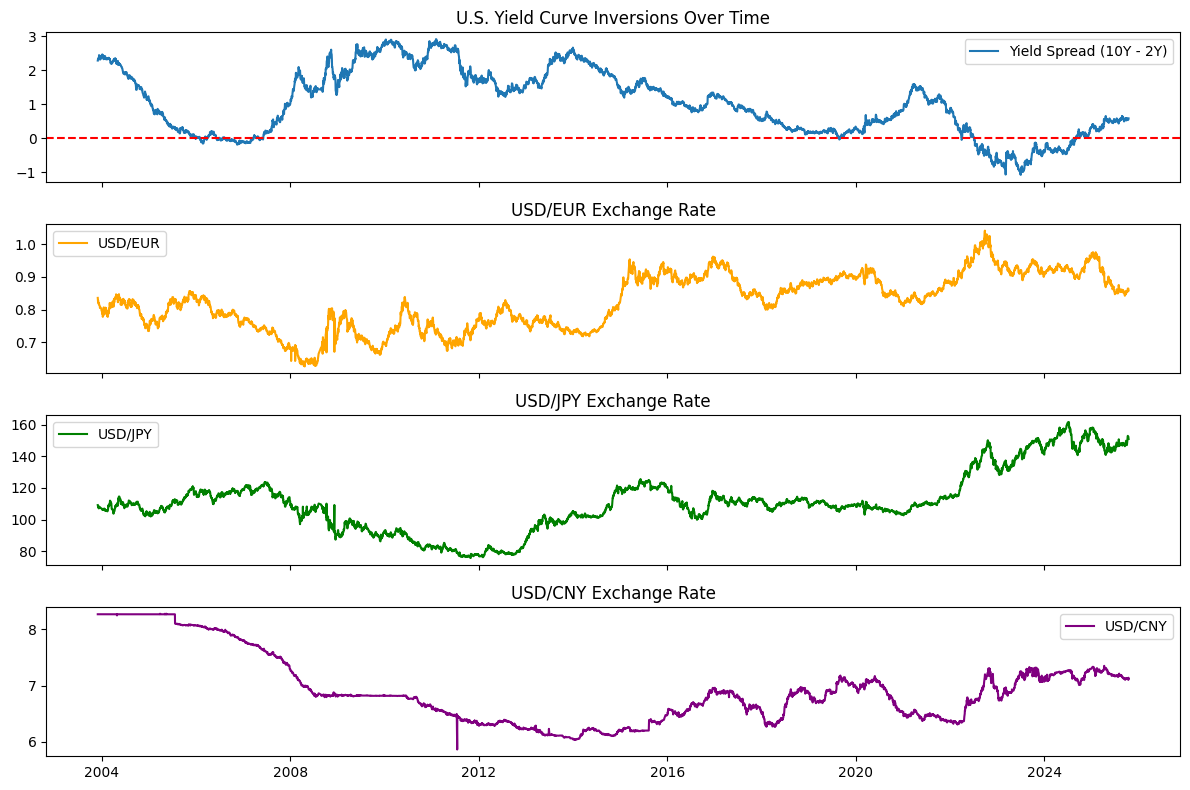

In [ ]:

fig, ax = plt.subplots(4, 1, figsize=(12,8), sharex=True)
ax[0].plot(data.index, data['Yield_Spread'], label='Yield Spread (10Y - 2Y)')
ax[0].axhline(0, color='r', linestyle='--')
ax[0].set_title("U.S. Yield Curve Inversions Over Time")
ax[0].legend()

ax[1].plot(data.index, data['USDEUR'], label='USD/EUR', color='orange')
ax[1].set_title("USD/EUR Exchange Rate")
ax[1].legend()

ax[2].plot(data.index, data['USDJPY'], label='USD/JPY', color='green')
ax[2].set_title("USD/JPY Exchange Rate")
ax[2].legend()

ax[3].plot(data.index, data['USDCNY'], label='USD/CNY', color='purple')
ax[3].set_title("USD/CNY Exchange Rate")
ax[3].legend()
plt.tight_layout()
plt.show()


## 📊  Statistical Relationship: Yield Curve vs. FX Returns Part 1: Linear Regression

Testing different lag periods for monthly average USDEUR, USDJPY, and USDCNY returns...

Best lag found for USDEUR returns: 100 days with R-squared: 0.0154
Best lag found for USDJPY returns: 0 days with R-squared: 0.0041
Best lag found for USDCNY returns: 0 days with R-squared: 0.0057


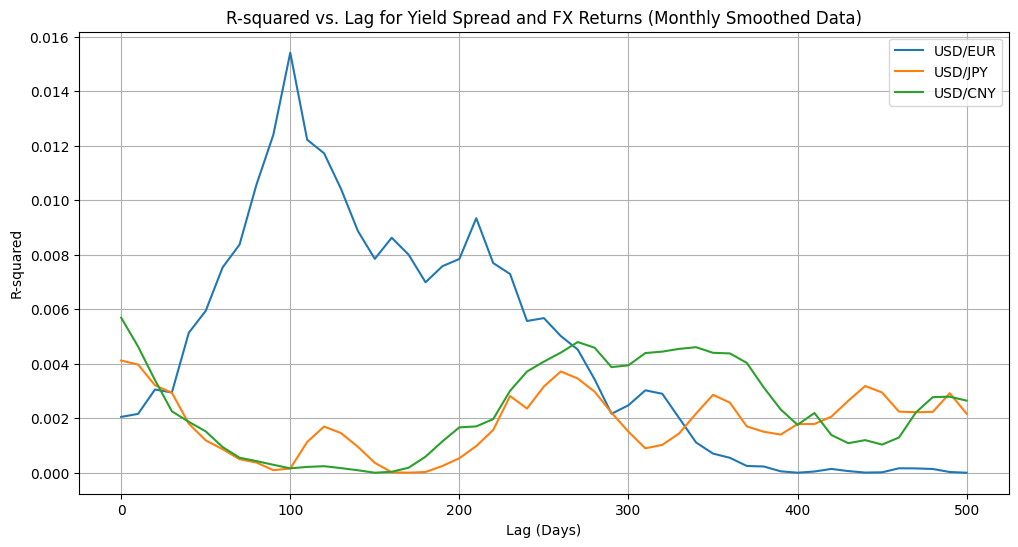


Model Summary for Monthly USDEUR Returns at Best Lag (Monthly Smoothed Yield Spread):
                            OLS Regression Results                            
Dep. Variable:     USDEUR_ret_Monthly   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.023
Date:                Sun, 19 Oct 2025   Prob (F-statistic):             0.0459
Time:                        23:55:03   Log-Likelihood:                 1326.1
No. Observations:                 259   AIC:                            -2648.
Df Residuals:                     257   BIC:                            -2641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [ ]:
max_lag_days = 2 * 252 # Approximately 2 years of trading days
step_days = 10
best_r_squared_eur = -1
best_lag_eur = -1
best_r_squared_jpy = -1
best_lag_jpy = -1
best_r_squared_cny = -1
best_lag_cny = -1

lag_results = {'Lag': [], 'USDEUR_Rsquared': [], 'USDJPY_Rsquared': [], 'USDCNY_Rsquared': []}


print("Testing different lag periods for monthly average USDEUR, USDJPY, and USDCNY returns...")

# Calculate monthly average FX returns once outside the lag loop
usdeur_ret_monthly = data['USDEUR_ret'].resample('ME').mean()
usdjpy_ret_monthly = data['USDJPY_ret'].resample('ME').mean()
usdcny_ret_monthly = data['USDCNY_ret'].resample('ME').mean()


for lag in range(0, max_lag_days + 1, step_days):
    data['Yield_Spread_Lag'] = data['Yield_Spread'].shift(lag)

    # Smooth the Yield_Spread_Lag by taking the average of each month
    yield_spread_lag_monthly = data['Yield_Spread_Lag'].resample('ME').mean()

    # Join the monthly smoothed yield spread with the monthly average FX returns for modeling
    model_data = pd.DataFrame({
        'USDEUR_ret_Monthly': usdeur_ret_monthly,
        'USDJPY_ret_Monthly': usdjpy_ret_monthly,
        'USDCNY_ret_Monthly': usdcny_ret_monthly,
        'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly
    }).dropna()


    if not model_data.empty:
        X = sm.add_constant(model_data['Yield_Spread_Lag_Monthly'])
        y_eur = model_data['USDEUR_ret_Monthly']
        y_jpy = model_data['USDJPY_ret_Monthly']
        y_cny = model_data['USDCNY_ret_Monthly']

        try:
            model_eur = sm.OLS(y_eur, X).fit()
            if model_eur.rsquared > best_r_squared_eur:
                best_r_squared_eur = model_eur.rsquared
                best_lag_eur = lag
            # print(f"Lag: {lag} days, USDEUR R-squared: {model_eur.rsquared:.4f}") # Optional: uncomment

            model_jpy = sm.OLS(y_jpy, X).fit()
            if model_jpy.rsquared > best_r_squared_jpy:
                best_r_squared_jpy = model_jpy.rsquared
                best_lag_jpy = lag
            # print(f"Lag: {lag} days, USDJPY R-squared: {model_jpy.rsquared:.4f}") # Optional: uncomment

            model_cny = sm.OLS(y_cny, X).fit()
            if model_cny.rsquared > best_r_squared_cny:
                best_r_squared_cny = model_cny.rsquared
                best_lag_cny = lag
            # print(f"Lag: {lag} days, USDCNY R-squared: {model_cny.rsquared:.4f}") # Optional: uncomment

            lag_results['Lag'].append(lag)
            lag_results['USDEUR_Rsquared'].append(model_eur.rsquared)
            lag_results['USDJPY_Rsquared'].append(model_jpy.rsquared)
            lag_results['USDCNY_Rsquared'].append(model_cny.rsquared)


        except ValueError as e:
            print(f"Could not fit model for lag {lag}: {e}")
            pass # Continue to the next lag if model fitting fails

print(f"\nBest lag found for USDEUR returns: {best_lag_eur} days with R-squared: {best_r_squared_eur:.4f}")
print(f"Best lag found for USDJPY returns: {best_lag_jpy} days with R-squared: {best_r_squared_jpy:.4f}")
print(f"Best lag found for USDCNY returns: {best_lag_cny} days with R-squared: {best_r_squared_cny:.4f}")


# Create a DataFrame from lag_results
lag_results_df = pd.DataFrame(lag_results)

# Plotting the R-squared values for each currency against lag
plt.figure(figsize=(12, 6))
plt.plot(lag_results_df['Lag'], lag_results_df['USDEUR_Rsquared'], label='USD/EUR')
plt.plot(lag_results_df['Lag'], lag_results_df['USDJPY_Rsquared'], label='USD/JPY')
plt.plot(lag_results_df['Lag'], lag_results_df['USDCNY_Rsquared'], label='USD/CNY')
plt.xlabel('Lag (Days)')
plt.ylabel('R-squared')
plt.title('R-squared vs. Lag for Yield Spread and FX Returns (Monthly Smoothed Data)')
plt.legend()
plt.grid(True)
plt.show()


# Fit the model with the best lag for USDEUR for final summary
if best_lag_eur != -1:
    data['Yield_Spread_Lag_EUR'] = data['Yield_Spread'].shift(best_lag_eur)
    yield_spread_lag_monthly_eur = data['Yield_Spread_Lag_EUR'].resample('ME').mean()
    model_data_eur = pd.DataFrame({
        'USDEUR_ret_Monthly': usdeur_ret_monthly,
        'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly_eur
    }).dropna()


    X_eur = sm.add_constant(model_data_eur['Yield_Spread_Lag_Monthly'])
    y_eur = model_data_eur['USDEUR_ret_Monthly']
    model_eur = sm.OLS(y_eur, X_eur).fit()
    print("\nModel Summary for Monthly USDEUR Returns at Best Lag (Monthly Smoothed Yield Spread):")
    print(model_eur.summary())
else:
    print("\nCould not find a suitable lag to fit a model for monthly USDEUR returns.")

# Fit the model with the best lag for USDJPY for final summary
if best_lag_jpy != -1:
    data['Yield_Spread_Lag_JPY'] = data['Yield_Spread'].shift(best_lag_jpy)
    yield_spread_lag_monthly_jpy = data['Yield_Spread_Lag_JPY'].resample('ME').mean()
    model_data_jpy = pd.DataFrame({
        'USDJPY_ret_Monthly': usdjpy_ret_monthly,
        'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly_jpy
    }).dropna()
    X_jpy = sm.add_constant(model_data_jpy['Yield_Spread_Lag_Monthly'])
    y_jpy = model_data_jpy['USDJPY_ret_Monthly']
    model_jpy = sm.OLS(y_jpy, X_jpy).fit()
    print("\nModel Summary for Monthly USDJPY Returns at Best Lag (Monthly Smoothed Yield Spread):")
    print(model_jpy.summary())
else:
    print("\nCould not find a suitable lag to fit a model for monthly USDJPY returns.")

# Fit the model with the best lag for USDCNY for final summary
if best_lag_cny != -1:
    data['Yield_Spread_Lag_CNY'] = data['Yield_Spread'].shift(best_lag_cny)
    yield_spread_lag_monthly_cny = data['Yield_Spread_Lag_CNY'].resample('ME').mean()
    model_data_cny = pd.DataFrame({
        'USDCNY_ret_Monthly': usdcny_ret_monthly,
        'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly_cny
    }).dropna()
    X_cny = sm.add_constant(model_data_cny['Yield_Spread_Lag_Monthly'])
    y_cny = model_data_cny['USDCNY_ret_Monthly']
    model_cny = sm.OLS(y_cny, X_cny).fit()
    print("\nModel Summary for Monthly USDCNY Returns at Best Lag (Monthly Smoothed Yield Spread):")
    print(model_cny.summary())
else:
    print("\nCould not find a suitable lag to fit a model for monthly USDCNY returns.")

## 🧾 Discussion & Insights

**Findings:**  
Given the amount of noise in the data, and even with three available currencies as EUR, Yen, and the Renminbi, there was no statistcal correlation between the Yield Curve and the exchanges.  Attempted lag ranges were tried from 10 day lag to 2 year lag range, and smoothing of the data by monthly mean.  However, neither were enough to provide predictive power of Yield Curve to currency exchanges.  

## 📊 Statistical Relationship: Yield Curve vs. FX Returns Part 2: Logistic Regression

Testing different lag periods for predicting monthly FX return direction (Logistic Regression)...

Best lag found for USDEUR direction: 400 days with Pseudo R-squared: 0.0026
Best lag found for USDJPY direction: 0 days with Pseudo R-squared: 0.0114
Best lag found for USDCNY direction: 10 days with Pseudo R-squared: 0.0031


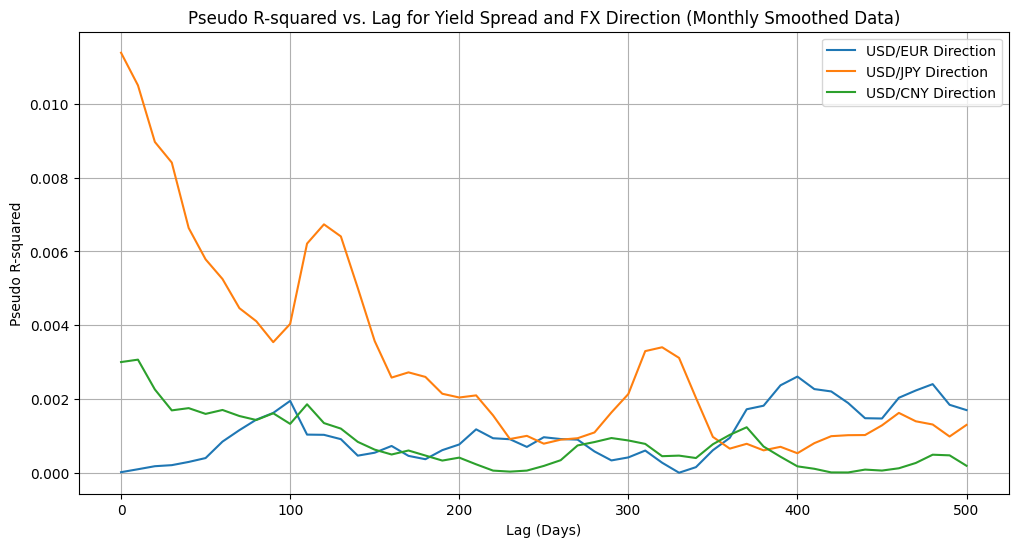


Model Summary for Monthly USDEUR Direction at Best Lag (Monthly Smoothed Yield Spread):
                           Logit Regression Results                           
Dep. Variable:       USDEUR_Direction   No. Observations:                  244
Model:                          Logit   Df Residuals:                      242
Method:                           MLE   Df Model:                            1
Date:                Sun, 19 Oct 2025   Pseudo R-squ.:                0.002608
Time:                        23:55:35   Log-Likelihood:                -168.68
converged:                       True   LL-Null:                       -169.12
Covariance Type:            nonrobust   LLR p-value:                    0.3477
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1529      0.194      0.788      0.431      -0.228       0.533


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

max_lag_days = 2 * 252 # Approximately 2 years of trading days
step_days = 10
best_r_squared_eur = -1
best_lag_eur = -1
best_r_squared_jpy = -1
best_lag_jpy = -1
best_r_squared_cny = -1
best_lag_cny = -1

lag_results_logit = {'Lag': [], 'USDEUR_Pseudo_Rsquared': [], 'USDJPY_Pseudo_Rsquared': [], 'USDCNY_Pseudo_Rsquared': []}


print("Testing different lag periods for predicting monthly FX return direction (Logistic Regression)...")

# Calculate monthly average FX returns and create binary target variables
# Ensure 'data' DataFrame is available from previous cells
if 'data' in locals():
    usdeur_ret_monthly = data['USDEUR_ret'].resample('ME').mean()
    usdjpy_ret_monthly = data['USDJPY_ret'].resample('ME').mean()
    usdcny_ret_monthly = data['USDCNY_ret'].resample('ME').mean()

    usdeur_direction_monthly = (usdeur_ret_monthly > 0).astype(int)
    usdjpy_direction_monthly = (usdjpy_ret_monthly > 0).astype(int)
    usdcny_direction_monthly = (usdcny_ret_monthly > 0).astype(int)


    for lag in range(0, max_lag_days + 1, step_days):
        data['Yield_Spread_Lag'] = data['Yield_Spread'].shift(lag)

        # Smooth the Yield_Spread_Lag by taking the average of each month
        yield_spread_lag_monthly = data['Yield_Spread_Lag'].resample('ME').mean()

        # Create model data by joining monthly smoothed yield spread with monthly FX direction
        model_data = pd.DataFrame({
            'USDEUR_Direction': usdeur_direction_monthly,
            'USDJPY_Direction': usdjpy_direction_monthly,
            'USDCNY_Direction': usdcny_direction_monthly,
            'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly
        }).dropna()


        if not model_data.empty:
            X = sm.add_constant(model_data['Yield_Spread_Lag_Monthly'])
            y_eur = model_data['USDEUR_Direction']
            y_jpy = model_data['USDJPY_Direction']
            y_cny = model_data['USDCNY_Direction']

            # Ensure there is variation in the target variable for logistic regression
            if y_eur.nunique() > 1:
                try:
                    model_eur = sm.Logit(y_eur, X).fit(disp=0) # disp=0 to suppress optimization output
                    if model_eur.prsquared > best_r_squared_eur:
                        best_r_squared_eur = model_eur.prsquared
                        best_lag_eur = lag
                    # print(f"Lag: {lag} days, USDEUR Pseudo R-squared: {model_eur.prsquared:.4f}") # Optional: uncomment
                except Exception as e: # Catching general exception for robustness
                    print(f"Could not fit USDEUR model for lag {lag}: {e}")
                    pass # Continue to the next lag if model fitting fails
            else:
                 # print(f"Lag: {lag} days, Skipping USDEUR model due to no variation in direction.") # Optional: uncomment
                 pass


            if y_jpy.nunique() > 1:
                try:
                    model_jpy = sm.Logit(y_jpy, X).fit(disp=0) # disp=0 to suppress optimization output
                    if model_jpy.prsquared > best_r_squared_jpy:
                        best_r_squared_jpy = model_jpy.prsquared
                        best_lag_jpy = lag
                    # print(f"Lag: {lag} days, USDJPY Pseudo R-squared: {model_jpy.prsquared:.4f}") # Optional: uncomment
                except Exception as e: # Catching general exception for robustness
                    print(f"Could not fit USDJPY model for lag {lag}: {e}")
                    pass # Continue to the next lag if model fitting fails
            else:
                 # print(f"Lag: {lag} days, Skipping USDJPY model due to no variation in direction.") # Optional: uncomment
                 pass

            if y_cny.nunique() > 1:
                try:
                    model_cny = sm.Logit(y_cny, X).fit(disp=0) # disp=0 to suppress optimization output
                    if model_cny.prsquared > best_r_squared_cny:
                        best_r_squared_cny = model_cny.prsquared
                        best_lag_cny = lag
                    # print(f"Lag: {lag} days, USDCNY Pseudo R-squared: {model_cny.prsquared:.4f}") # Optional: uncomment
                except Exception as e: # Catching general exception for robustness
                    print(f"Could not fit USDCNY model for lag {lag}: {e}")
                    pass # Continue to the next lag if model fitting fails
            else:
                 # print(f"Lag: {lag} days, Skipping USDCNY model due to no variation in direction.") # Optional: uncomment
                 pass

            # Only append results if at least one model was fitted in this lag
            if 'model_eur' in locals() or 'model_jpy' in locals() or 'model_cny' in locals():
                 lag_results_logit['Lag'].append(lag)
                 lag_results_logit['USDEUR_Pseudo_Rsquared'].append(model_eur.prsquared if 'model_eur' in locals() else None)
                 lag_results_logit['USDJPY_Pseudo_Rsquared'].append(model_jpy.prsquared if 'model_jpy' in locals() else None)
                 lag_results_logit['USDCNY_Pseudo_Rsquared'].append(model_cny.prsquared if 'model_cny' in locals() else None)



    print(f"\nBest lag found for USDEUR direction: {best_lag_eur} days with Pseudo R-squared: {best_r_squared_eur:.4f}")
    print(f"Best lag found for USDJPY direction: {best_lag_jpy} days with Pseudo R-squared: {best_r_squared_jpy:.4f}")
    print(f"Best lag found for USDCNY direction: {best_lag_cny} days with Pseudo R-squared: {best_r_squared_cny:.4f}")


    # Create a DataFrame from lag_results
    lag_results_logit_df = pd.DataFrame(lag_results_logit)

    # Plotting the Pseudo R-squared values for each currency against lag
    plt.figure(figsize=(12, 6))
    plt.plot(lag_results_logit_df['Lag'], lag_results_logit_df['USDEUR_Pseudo_Rsquared'], label='USD/EUR Direction')
    plt.plot(lag_results_logit_df['Lag'], lag_results_logit_df['USDJPY_Pseudo_Rsquared'], label='USD/JPY Direction')
    plt.plot(lag_results_logit_df['Lag'], lag_results_logit_df['USDCNY_Pseudo_Rsquared'], label='USD/CNY Direction')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Pseudo R-squared')
    plt.title('Pseudo R-squared vs. Lag for Yield Spread and FX Direction (Monthly Smoothed Data)')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Fit the model with the best lag for USDEUR for final summary
    if best_lag_eur != -1:
        data['Yield_Spread_Lag_EUR'] = data['Yield_Spread'].shift(best_lag_eur)
        yield_spread_lag_monthly_eur = data['Yield_Spread_Lag_EUR'].resample('ME').mean()
        model_data_eur = pd.DataFrame({
            'USDEUR_Direction': usdeur_direction_monthly,
            'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly_eur
        }).dropna()

        if model_data_eur['USDEUR_Direction'].nunique() > 1:
            X_eur = sm.add_constant(model_data_eur['Yield_Spread_Lag_Monthly'])
            y_eur = model_data_eur['USDEUR_Direction']
            model_eur = sm.Logit(y_eur, X_eur).fit(disp=0)
            print("\nModel Summary for Monthly USDEUR Direction at Best Lag (Monthly Smoothed Yield Spread):")
            print(model_eur.summary())
        else:
            print("\nCould not fit model for monthly USDEUR direction at best lag due to no variation.")

    else:
        print("\nCould not find a suitable lag to fit a model for monthly USDEUR direction.")

    # Fit the model with the best lag for USDJPY for final summary
    if best_lag_jpy != -1:
        data['Yield_Spread_Lag_JPY'] = data['Yield_Spread'].shift(best_lag_jpy)
        yield_spread_lag_monthly_jpy = data['Yield_Spread_Lag_JPY'].resample('ME').mean()
        model_data_jpy = pd.DataFrame({
            'USDJPY_Direction': usdjpy_direction_monthly,
            'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly_jpy
        }).dropna()

        if model_data_jpy['USDJPY_Direction'].nunique() > 1:
            X_jpy = sm.add_constant(model_data_jpy['Yield_Spread_Lag_Monthly'])
            y_jpy = model_data_jpy['USDJPY_Direction']
            model_jpy = sm.Logit(y_jpy, X_jpy).fit(disp=0)
            print("\nModel Summary for Monthly USDJPY Direction at Best Lag (Monthly Smoothed Yield Spread):")
            print(model_jpy.summary())
        else:
            print("\nCould not fit model for monthly USDJPY direction at best lag due to no variation.")
    else:
        print("\nCould not find a suitable lag to fit a model for monthly USDJPY direction.")

    # Fit the model with the best lag for USDCNY for final summary
    if best_lag_cny != -1:
        data['Yield_Spread_Lag_CNY'] = data['Yield_Spread'].shift(best_lag_cny)
        yield_spread_lag_monthly_cny = data['Yield_Spread_Lag_CNY'].resample('ME').mean()
        model_data_cny = pd.DataFrame({
            'USDCNY_Direction': usdcny_direction_monthly,
            'Yield_Spread_Lag_Monthly': yield_spread_lag_monthly_cny
        }).dropna()

        if model_data_cny['USDCNY_Direction'].nunique() > 1:
            X_cny = sm.add_constant(model_data_cny['Yield_Spread_Lag_Monthly'])
            y_cny = model_data_cny['USDCNY_Direction']
            model_cny = sm.Logit(y_cny, X_cny).fit(disp=0)
            print("\nModel Summary for Monthly USDCNY Direction at Best Lag (Monthly Smoothed Yield Spread):")
            print(model_cny.summary())
        else:
            print("\nCould not fit model for monthly USDCNY direction at best lag due to no variation.")

    else:
        print("\nCould not find a suitable lag to fit a model for monthly USDCNY direction.")
else:
    print("Error: 'data' DataFrame not found. Please ensure the data loading cells have been run.")

## 🧾 Discussion & Insights

**Findings:**  
Switching to short term FX forecasting, an attempt was made to make a logistic regression model, to see if daily, weekly, or monthly FX changes could be used to predict an increase or decrease in the exchange rate.  Again, the noisiness in the data prevented us from creating a model with predictive power.

## 📊  Visualization: Relationship Summary

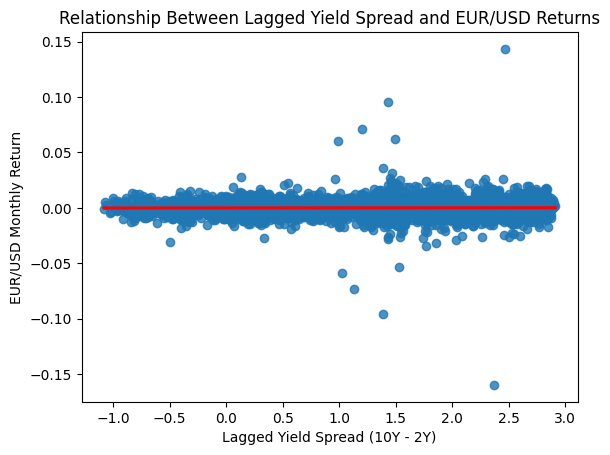

In [ ]:

sns.regplot(x='Yield_Spread_Lag1', y='USDEUR_ret', data=model_data, line_kws={'color':'red'})
plt.title('Relationship Between Lagged Yield Spread and USD/EUR Returns')
plt.xlabel('Lagged Yield Spread (10Y - 2Y)')
plt.ylabel('USD/EUR Monthly Return')
plt.show()



## 🧾 Ending Analysis

**Findings:**  
Historical yield curve inversions tend to precede USD appreciation periods (USD/EUR increases).  However, in practice this is a very difficult prediction, and only 10-30% of the variance is explained in the best case.  This projects showcases the first steps to building such a predictive model, and although shows little predictive success, can be extended to include other variables and metrics.


**Next steps:**  
- Build a model to estimate using interest rate differentials  
- Incorporate inflation from FRED using FRED API.  
- Deploy as a daily GitHub-scheduled pipeline or simple web dashboard.



## 📘 Appendix

**Data Sources:**  
- FRED: [https://fred.stlouisfed.org/](https://fred.stlouisfed.org/)  
- Yahoo Finance API via `yfinance`

**Packages:**  
- `pandas_datareader`, `yfinance`, `statsmodels`, `matplotlib`, `pandas`, `numpy`, `seaborn`
